### 長期間にわたる値のモニター

In [1]:
import subprocess
from subprocess import PIPE

def shell(command):
#    print(command)
    proc = subprocess.run(command, shell=True, stdout=PIPE, stderr=PIPE, text=True)
#    print(proc.stderr)
    return proc.stdout, proc.stderr

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime

In [2]:
def nextInputFilePath(inputFilePath):
    type = inputFilePath[15:16]
    year = int(inputFilePath[17:21])
    month = int(inputFilePath[21:23])
    day = int(inputFilePath[23:25])
    hour = int(inputFilePath[26:28])

    if hour == 8:
        hour = 17
        return f"/stars/{year}/TSC{type}-{year}{month:02d}{day:02d}-{hour:02d}.pkt"
    else:
        hour = 8
        _dateTime = datetime.datetime(year, month, day, hour, 0, 0) + datetime.timedelta(days=1)
        return f"/stars/{_dateTime.year}/TSC{type}-{_dateTime.year}{_dateTime.month:02d}{_dateTime.day:02d}-{hour:02d}.pkt"

In [3]:
def extractOutputFilePath(lines):
    for line in lines:
        if line.find('creating') >= 0:
            return line[11:]
    return ""


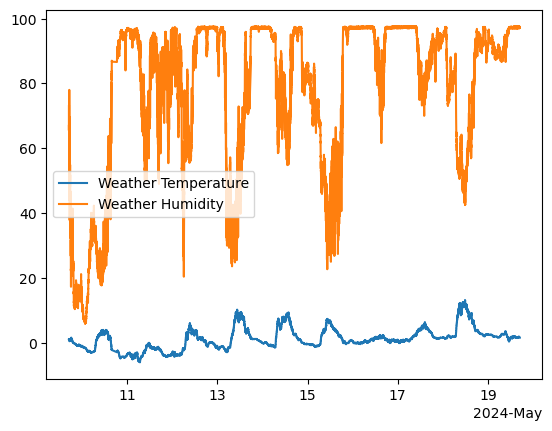

In [5]:
####
startDateTime = datetime.datetime(year=2024, month=5, day=10)
durationInDay = 10
## names = ["Mount S/D REF Alarm", "AZ CRS Alarm", "Mount Fault"]
names = ["Mount S/D REF Alarm"]
type = 'E' # 'E' 'L' 'S'
names = ["Weather Temperature", "Weather Humidity"]
type = 'L'
####

if type == 'E':
    _type = 'V'
else:
    _type = type
extractor = "dump-tsc-log -a -z"
#stopDateTime = startDateTime + datetime.timedelta(days=durationInDay)

logDay = startDateTime  + datetime.timedelta(days=-1)
inputFilePath = f"/stars/{logDay.year}/TSC{_type}-{logDay.year}{logDay.month:02}{logDay.day:02}-17.pkt"

tss = {}
for name in names:
    tss.setdefault(name, []) #tss = {'Mount S/D REF Alarm':[]} 辞書をnamesをkeysに初期化

for i in range(durationInDay*2):
    if not os.path.exists(inputFilePath):
        print(f"{inputFilePath} not exist")
        inputFilePath = nextInputFilePath(inputFilePath)
        continue

    extractNames = f''
    for name in names:
        extractNames += f'-e \"{name}\" '

    (_, outputText) = shell(f'{extractor} {extractNames} {inputFilePath}')

    outputFilePath = extractOutputFilePath(outputText.split('\n'))
    if not os.path.exists(outputFilePath):
        print(f"{outputFilePath} not exist {outputText}")
        inputFilePath = nextInputFilePath(inputFilePath)
        continue

    df = pd.read_table(outputFilePath)
    data = df.values
    df['datetime']= pd.to_datetime(df['#rxdate'] + ' ' + df['rxtime(HST)'])
    for j, name in zip(range(3, 3+len(names)), names):
        ts = pd.Series(data[:,j], index=df['datetime'])
        tss[name].append(ts)

    os.remove(outputFilePath)
    
    inputFilePath = nextInputFilePath(inputFilePath)

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

for name in names:
    joinedTs = tss[name][0]
    if len(tss[name]) > 1:
        for i in range(len(tss[name]) - 1):
            joinedTs = pd.concat([joinedTs, tss[name][i+1]]).sort_index()
        ax.plot(joinedTs, label=name)

plt.legend()
plt.show()